In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def single_sig_model(xi, theta):
    a1, a2, a3, a4 = theta[0], theta[1], theta[2], theta[3]
    return a1 + (a2-a1)/(1+math.exp(-a3*(xi-a4)))

In [5]:
num_points = 250

theta = np.array([0.0, 1.0, 0.15, 125])
x = torch.from_numpy(np.arange(num_points)).float()
f = np.array([single_sig_model(xi, theta) for xi in x])
noise = np.random.normal(loc=0, scale=0.1, size=num_points)
y = torch.from_numpy(f + noise).float()

samples = np.random.permutation(num_points)
train_samples = samples[:int(num_points*.8)]
test_samples = samples[int(num_points*.8):]

train_x, train_y, test_x, test_y = x[train_samples], y[train_samples], x[test_samples], y[test_samples]
train_x, train_y = train_x[train_x.argsort()], train_y[train_x.argsort()]
test_x, test_y = test_x[test_x.argsort()], test_y[test_x.argsort()]

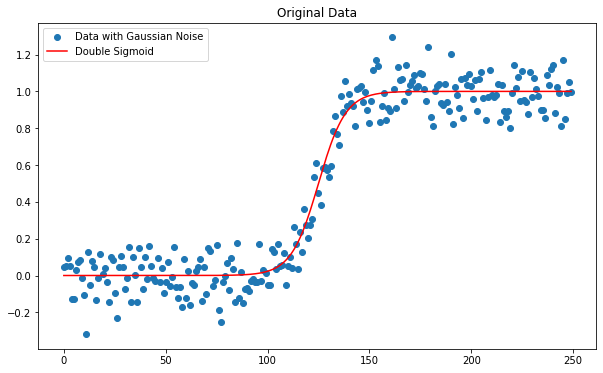

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, label = 'Data with Gaussian Noise')
plt.plot(f, color = 'red', label = 'Double Sigmoid')
plt.title('Original Data')
plt.legend()
plt.show()

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, mean = 0., kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module.constant = nn.Parameter(data = torch.tensor(mean), requires_grad = True)
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


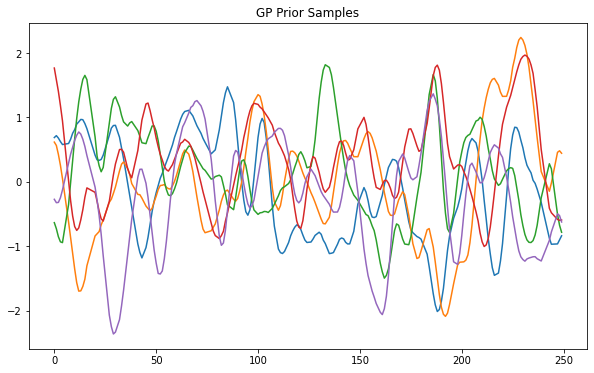

In [8]:
gp = ExactGPModel(
    train_x=x,
    train_y=None,
    likelihood=gpytorch.likelihoods.GaussianLikelihood(),
)

gp.covar_module.base_kernel.lengthscale = 5
gp.eval()

plt.figure(figsize=(10,6))
for i in range(5):
    f_samples = gp(train_x).sample()
    plt.plot(train_x, f_samples.detach())

plt.title('GP Prior Samples')
plt.show()

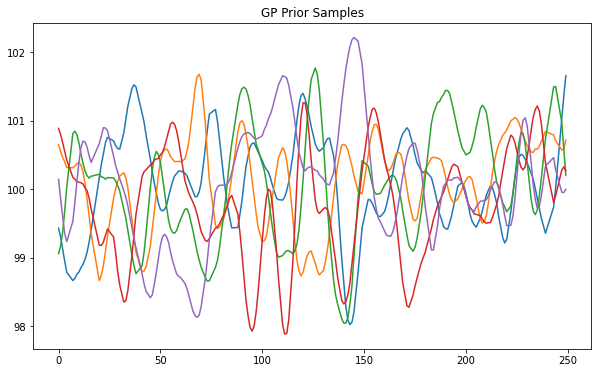

In [9]:
gp = ExactGPModel(
    train_x=x,
    train_y=None,
    likelihood=gpytorch.likelihoods.GaussianLikelihood(),
    mean = 100.
)

gp.covar_module.base_kernel.lengthscale = 5
gp.eval()

plt.figure(figsize=(10,6))
for i in range(5):
    f_samples = gp(train_x).sample()
    plt.plot(train_x, f_samples.detach())

plt.title('GP Prior Samples')
plt.show()

In [10]:
def plot_preds(model, likelihood): 
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 2, figsize=(20, 6))
        observed_train_pred = likelihood(model(train_x))
        observed_test_pred = likelihood(model(test_x))

        # Get upper and lower confidence bounds
        train_lower, train_upper = observed_train_pred.confidence_region()
        test_lower, test_upper = observed_test_pred.confidence_region()

        # Plot test data as black stars
        ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
        ax[1].plot(test_x.numpy(), test_y.numpy(), 'k*')

        # Plot predictive means as blue line
        ax[0].plot(train_x.numpy(), observed_train_pred.mean.numpy(), 'b')
        ax[1].plot(test_x.numpy(), observed_test_pred.mean.numpy(), 'b')

        # Shade between the lower and upper confidence bounds
        ax[0].fill_between(train_x.numpy(), train_lower.numpy(), train_upper.numpy(), alpha=0.5)
        ax[0].legend(['Train Data', 'Mean', '95% Conf. Int.'])
        ax[0].set_ylim([-0.3, 1.3])
        
        ax[1].fill_between(test_x.numpy(), test_lower.numpy(), test_upper.numpy(), alpha=0.5)
        ax[1].legend(['Test Data', 'Mean', '95% Conf. Int.'])
        ax[1].set_ylim([-0.3, 1.3])
        plt.show()
        
        return(observed_train_pred.mean.numpy(), observed_test_pred.mean.numpy())

BEFORE TRAINING
lengthscale: 5.000   noise: 0.693


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


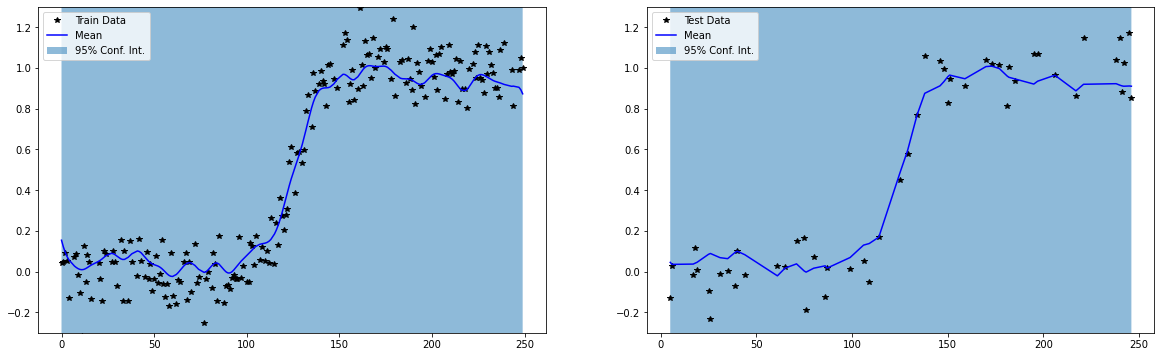

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 0/500 - Loss: 0.922   lengthscale: 5.099   noise: 0.644


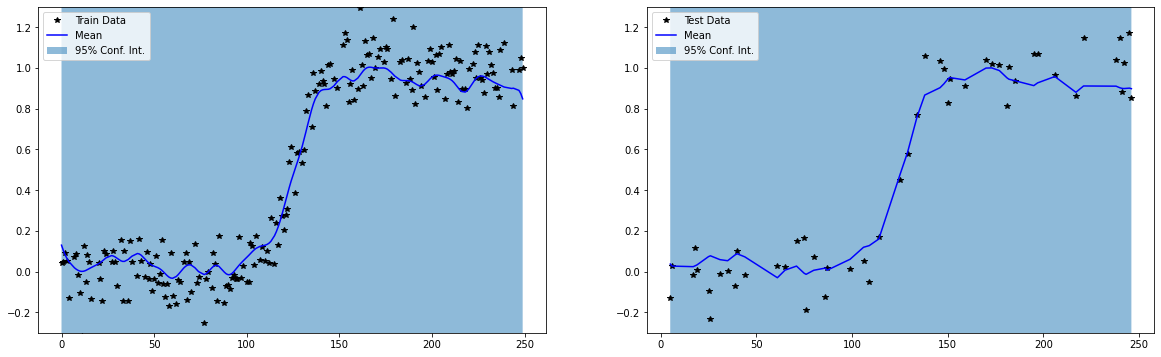

Iter 50/500 - Loss: -0.626   lengthscale: 10.251   noise: 0.009


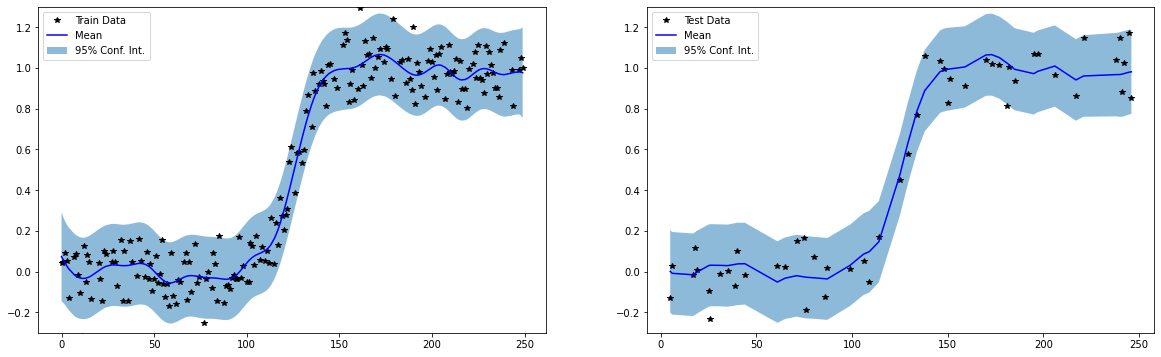

Iter 100/500 - Loss: -0.689   lengthscale: 14.454   noise: 0.010


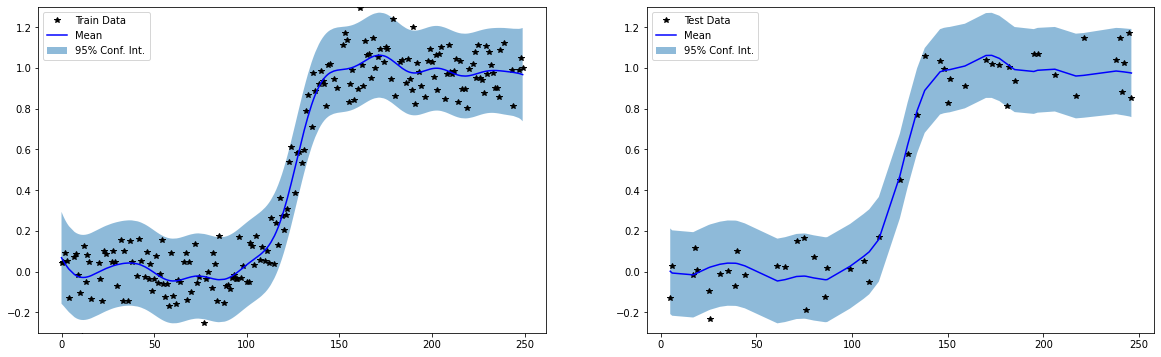

Iter 150/500 - Loss: -0.711   lengthscale: 17.158   noise: 0.010


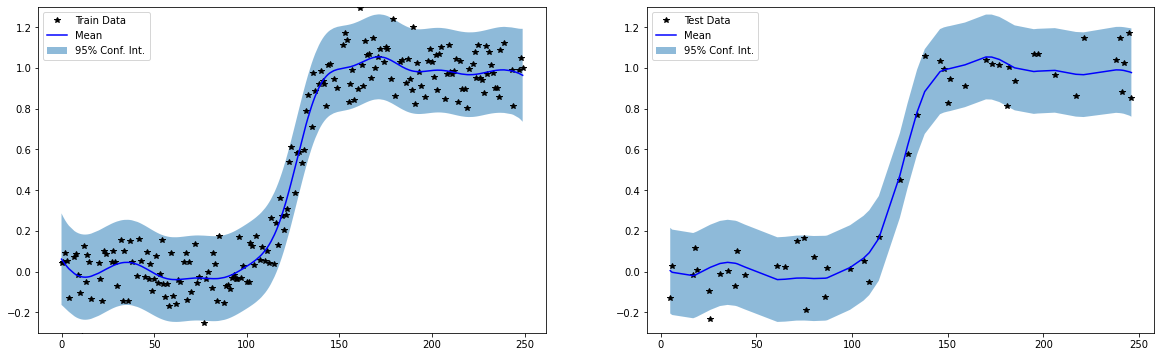

Iter 200/500 - Loss: -0.721   lengthscale: 19.163   noise: 0.010


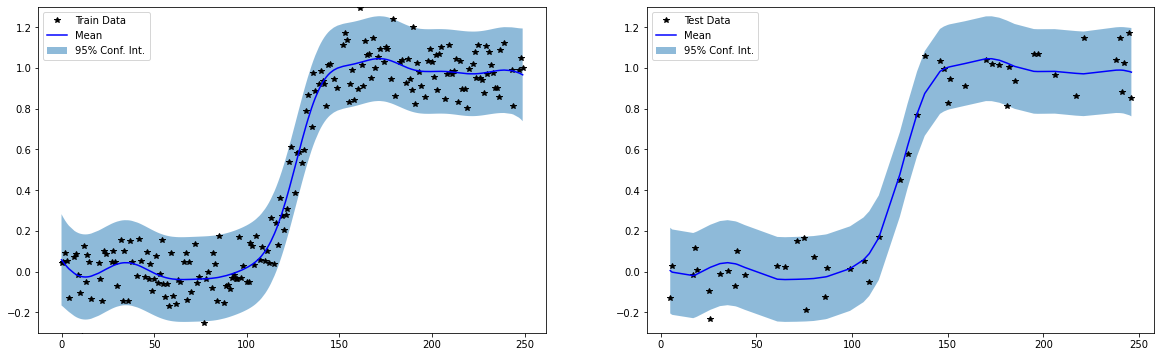

Iter 250/500 - Loss: -0.727   lengthscale: 20.810   noise: 0.010


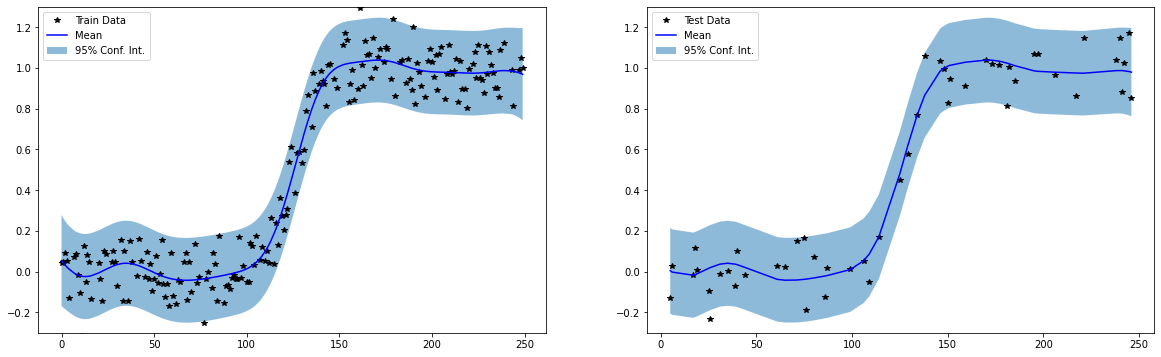

Iter 300/500 - Loss: -0.732   lengthscale: 22.322   noise: 0.010


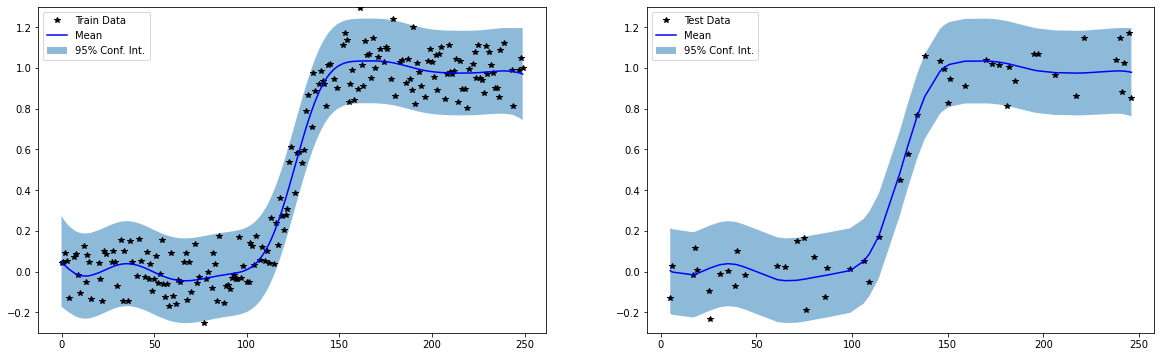

Iter 350/500 - Loss: -0.736   lengthscale: 23.770   noise: 0.010


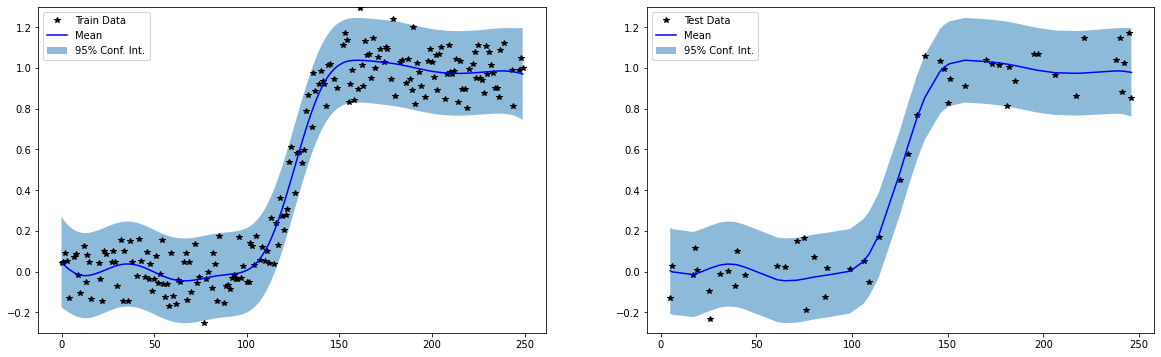

Iter 400/500 - Loss: -0.739   lengthscale: 25.095   noise: 0.010


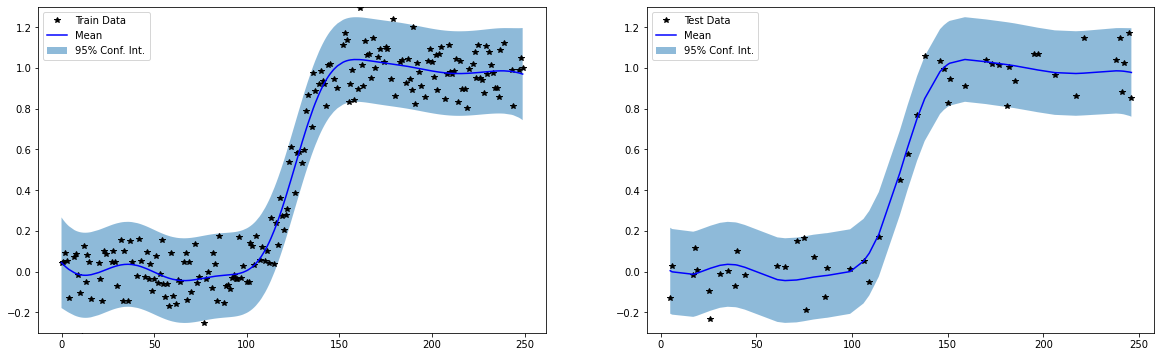

Iter 450/500 - Loss: -0.741   lengthscale: 26.217   noise: 0.010


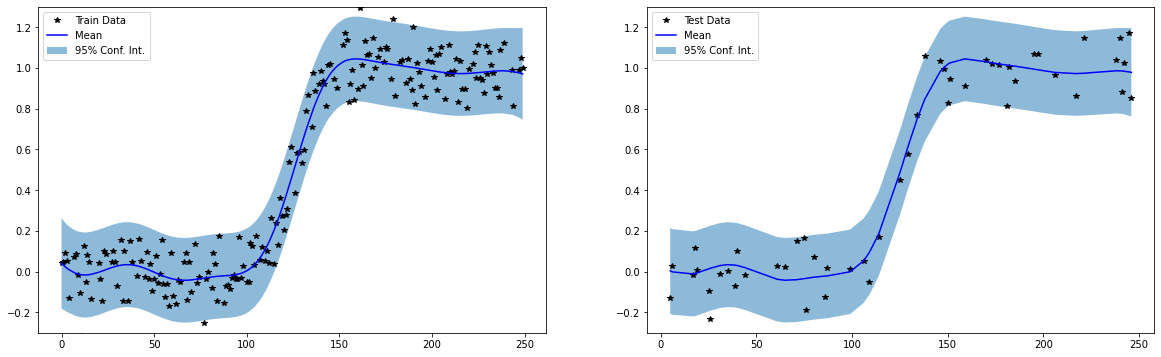

Iter 500/500 - Loss: -0.742   lengthscale: 27.106   noise: 0.010


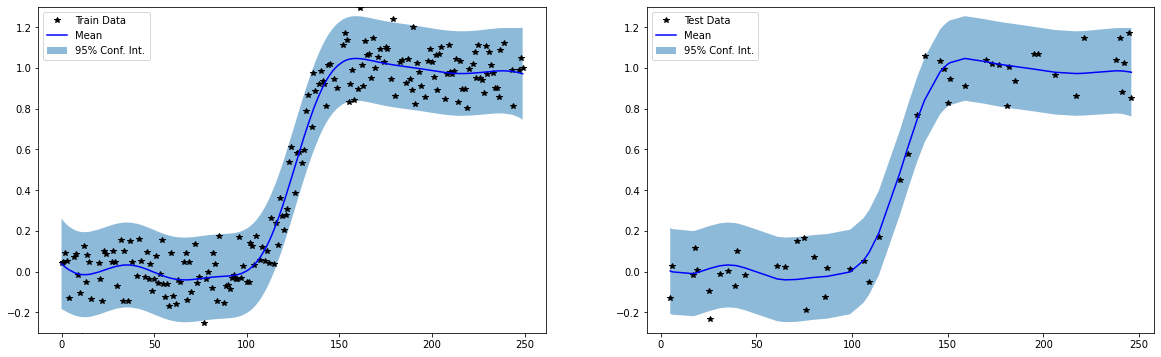

Train RMSE: 0.09811972826719284, Test RMSE: 0.10772734880447388


In [11]:
lengthscales = [5]

for l in lengthscales:
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, mean = 0.5)
    
    #set lengthscale
    model.covar_module.base_kernel.lengthscale = l
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(501):
        if i == 0:
            print('BEFORE TRAINING')
            print('lengthscale: %.3f   noise: %.3f' % (
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
            train_mean, test_mean = plot_preds(model, likelihood)
            
        model.train()
        likelihood.train()
        
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        
        optimizer.step()

        if i % 50 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i , 500, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
            
            train_mean, test_mean = plot_preds(model, likelihood)
            
            train_rmse = np.sqrt(np.mean((train_mean-train_y.numpy())**2))
            test_rmse = np.sqrt(np.mean((test_mean-test_y.numpy())**2))
            
            if i == 500:
                print('Train RMSE: {}, Test RMSE: {}'.format(train_rmse, test_rmse))

In [13]:
class OUKernel(gpytorch.kernels.Kernel):
    def __init__(self, log_lengthscale_prior=None):
        self.has_lengthscale=True
        super(OUKernel, self).__init__(has_lengthscale=True)
        self.register_parameter(name="isp_scale", 
                                parameter=torch.nn.Parameter(torch.zeros(1)))
        
    @property
    def scale(self):
        return torch.nn.functional.softplus(self.isp_scale)
        
    def forward(self, x1, x2, **params):
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        # make covariance grid
        diff = torch.sum(abs(x1_[:, None] - x2_[None, :]), -1)
        res = torch.exp(-diff) * self.scale
        return res

BEFORE TRAINING
lengthscale: 20.000   isp scale: 1.000   noise: 0.693


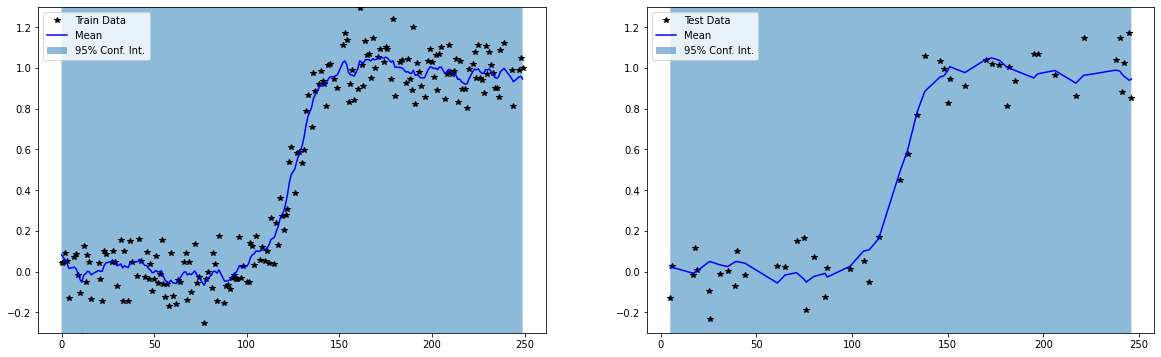

Iter 0/500 - Loss: 0.957   lengthscale: 20.100   isp scale: 0.900   noise: 0.644


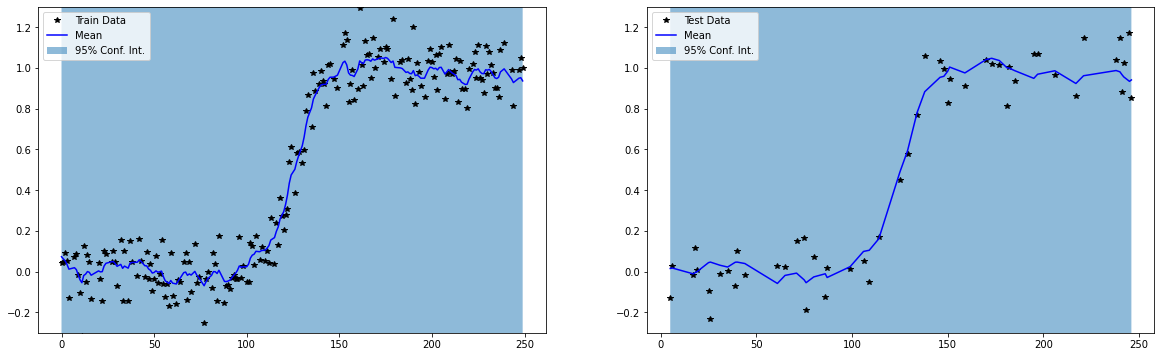

Iter 50/500 - Loss: -0.619   lengthscale: 25.143   isp scale: -3.390   noise: 0.008


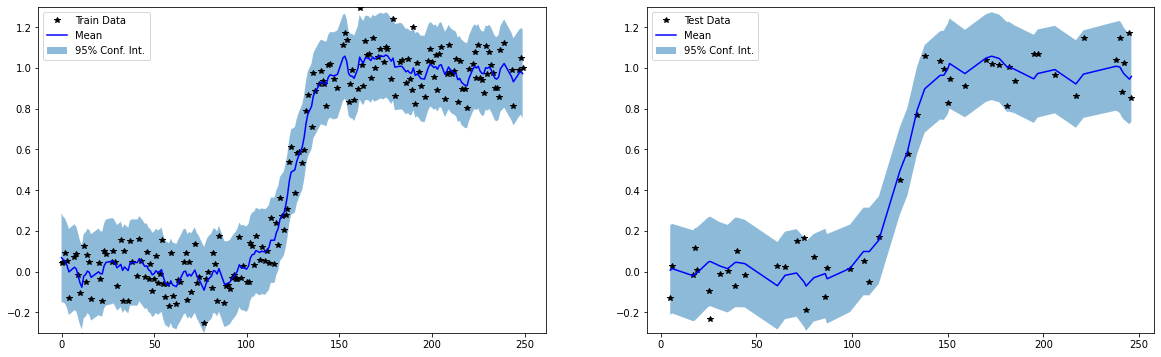

Iter 100/500 - Loss: -0.642   lengthscale: 29.405   isp scale: -3.099   noise: 0.009


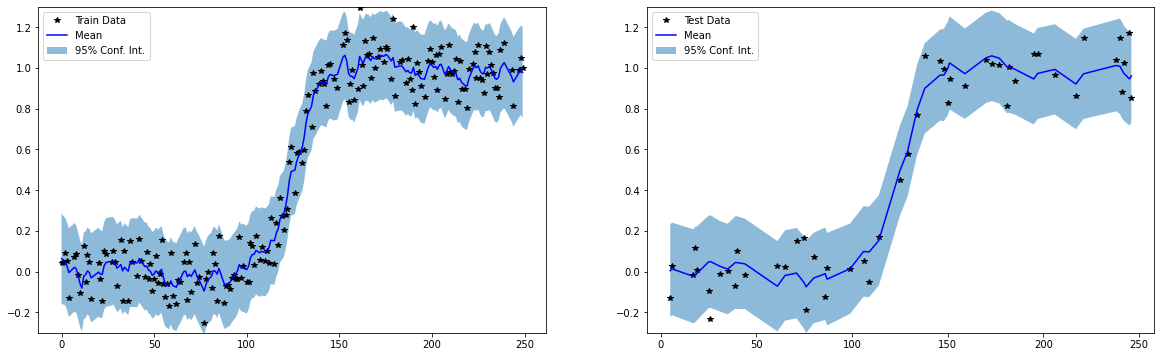

Iter 150/500 - Loss: -0.653   lengthscale: 33.131   isp scale: -3.030   noise: 0.009


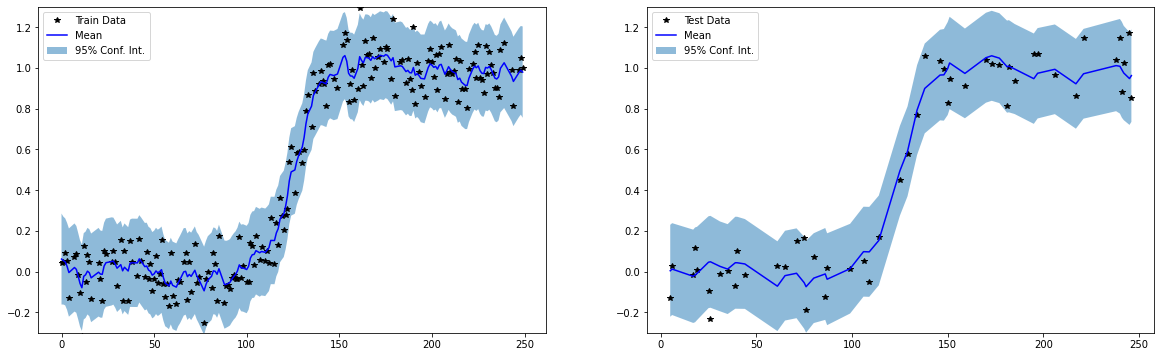

Iter 200/500 - Loss: -0.660   lengthscale: 36.432   isp scale: -3.020   noise: 0.009


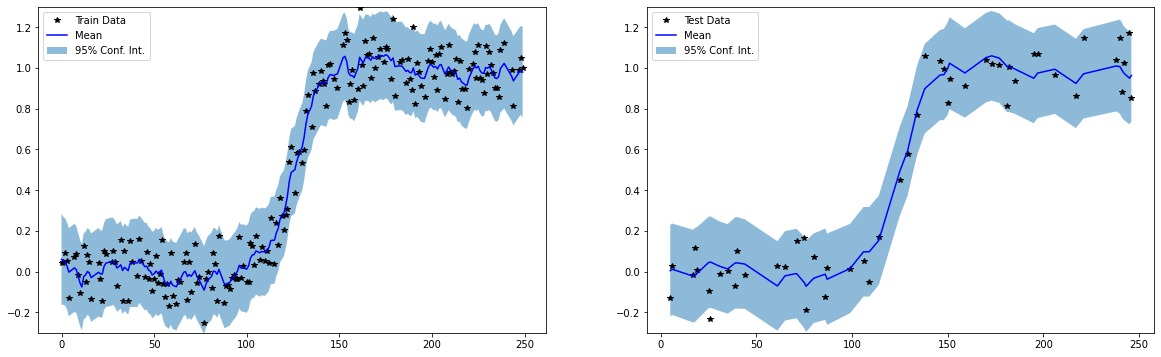

Iter 250/500 - Loss: -0.666   lengthscale: 39.434   isp scale: -3.008   noise: 0.009


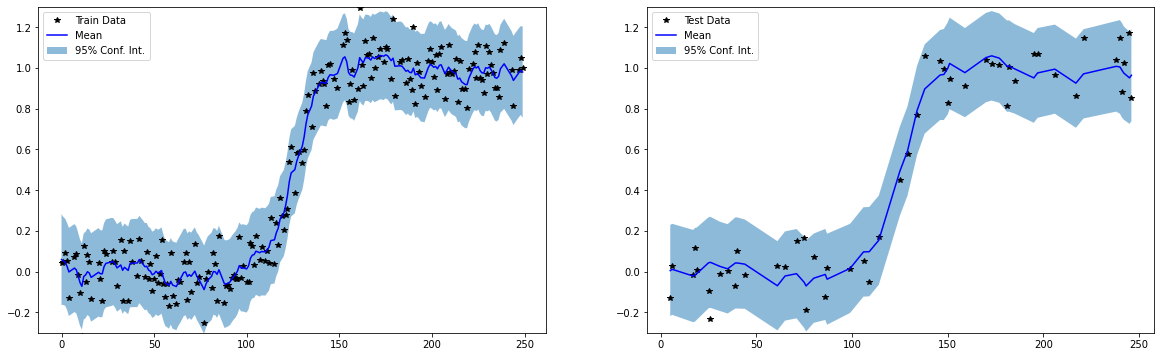

Iter 300/500 - Loss: -0.670   lengthscale: 42.207   isp scale: -2.995   noise: 0.009


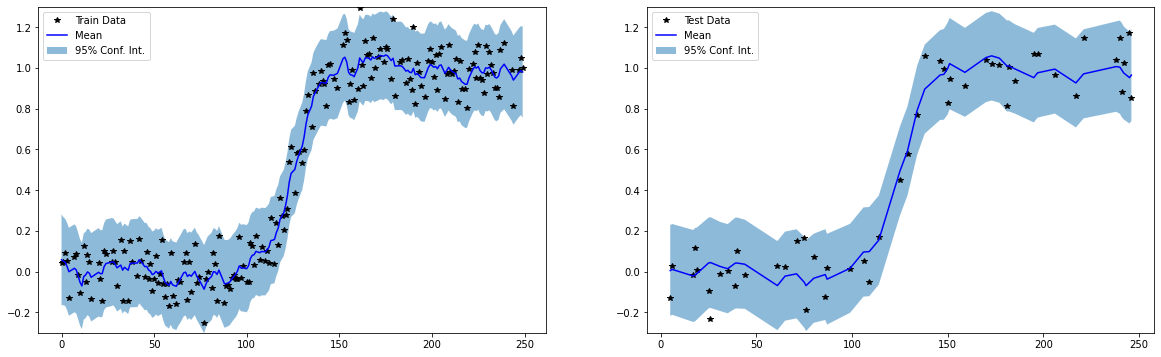

Iter 350/500 - Loss: -0.674   lengthscale: 44.798   isp scale: -2.982   noise: 0.009


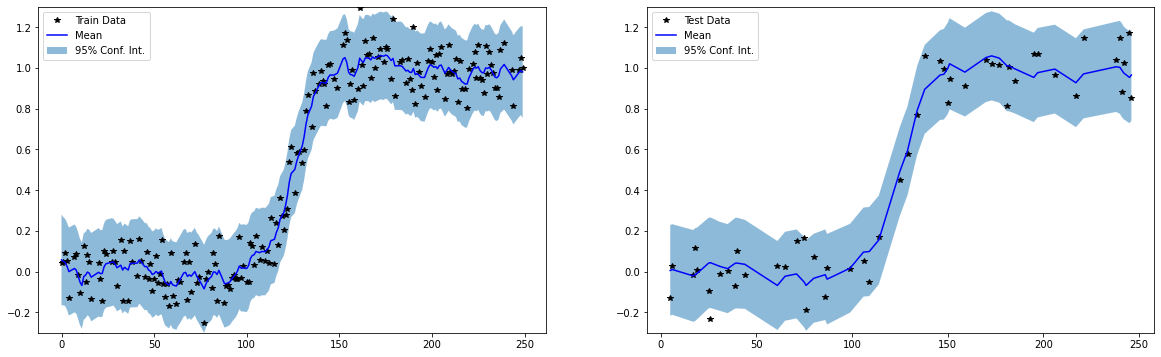

Iter 400/500 - Loss: -0.677   lengthscale: 47.238   isp scale: -2.968   noise: 0.009


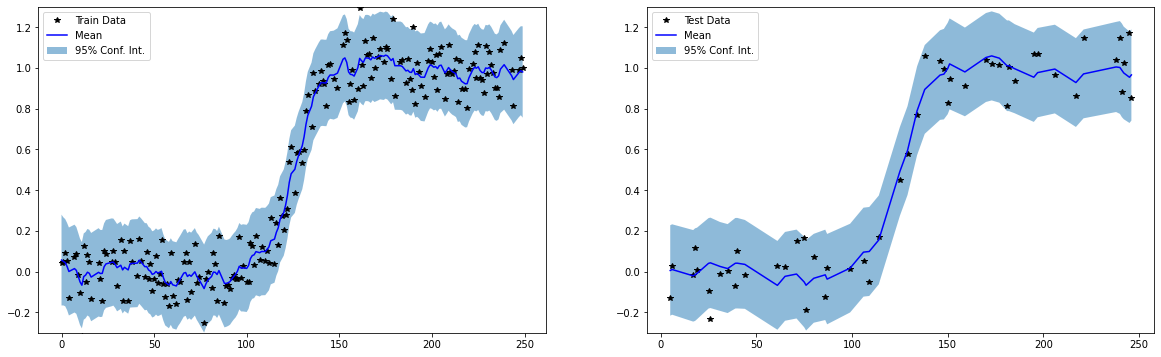

Iter 450/500 - Loss: -0.680   lengthscale: 49.551   isp scale: -2.953   noise: 0.009


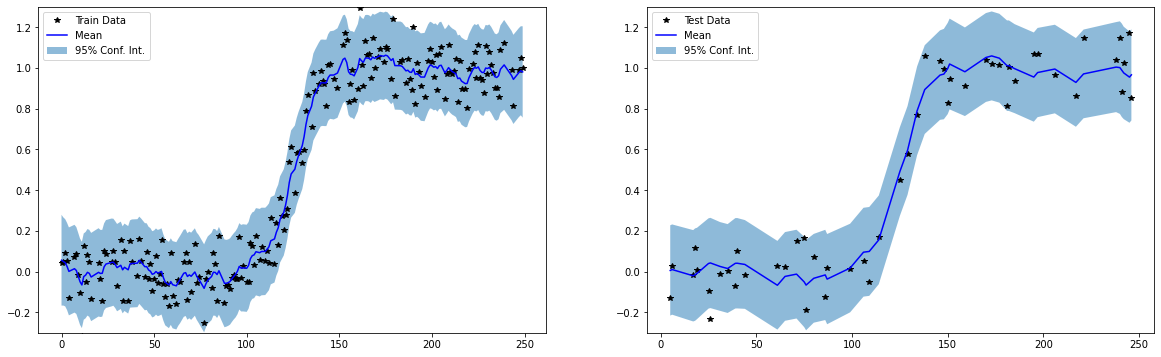

Iter 500/500 - Loss: -0.682   lengthscale: 51.756   isp scale: -2.939   noise: 0.009


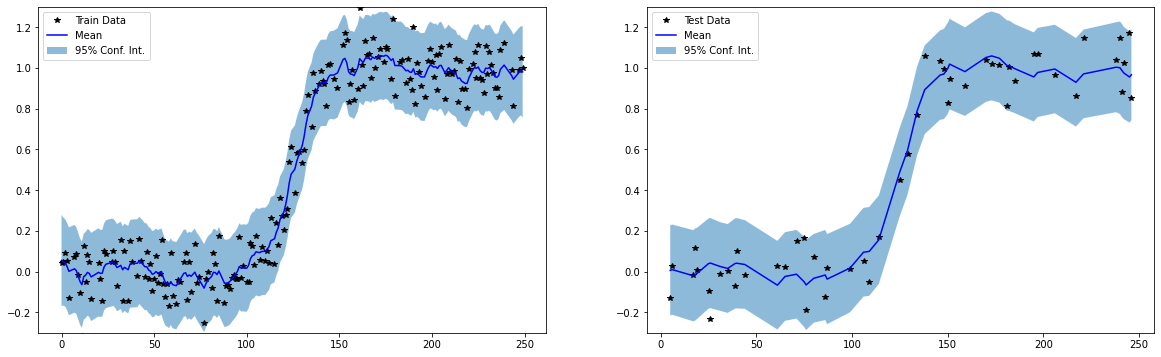

Train RMSE: 0.08262518048286438, Test RMSE: 0.10669370740652084


In [21]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

#set lengthscale and other parameters
ou_kernel = OUKernel()
ou_kernel.lengthscale = 20.
ou_kernel.isp_scale.data[0] = 1.

model = ExactGPModel(train_x, train_y, likelihood, mean = 0.5, kernel = ou_kernel)

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(501):
    if i == 0:
        print('BEFORE TRAINING')
        print('lengthscale: %.3f   isp scale: %.3f   noise: %.3f' % (
            model.covar_module.lengthscale.item(),
            model.covar_module.isp_scale.data[0],
            model.likelihood.noise.item()
        ))
        train_mean, test_mean = plot_preds(model, likelihood)

    model.train()
    likelihood.train()

    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()

    optimizer.step()

    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   isp scale: %.3f   noise: %.3f' % (
            i , 500, loss.item(),
            model.covar_module.lengthscale.item(),
            model.covar_module.isp_scale.data[0],
            model.likelihood.noise.item()
        ))

        train_mean, test_mean = plot_preds(model, likelihood)

        train_rmse = np.sqrt(np.mean((train_mean-train_y.numpy())**2))
        test_rmse = np.sqrt(np.mean((test_mean-test_y.numpy())**2))

        if i == 500:
            print('Train RMSE: {}, Test RMSE: {}'.format(train_rmse, test_rmse))

BEFORE TRAINING
lengthscale: 20.000   noise: 0.693


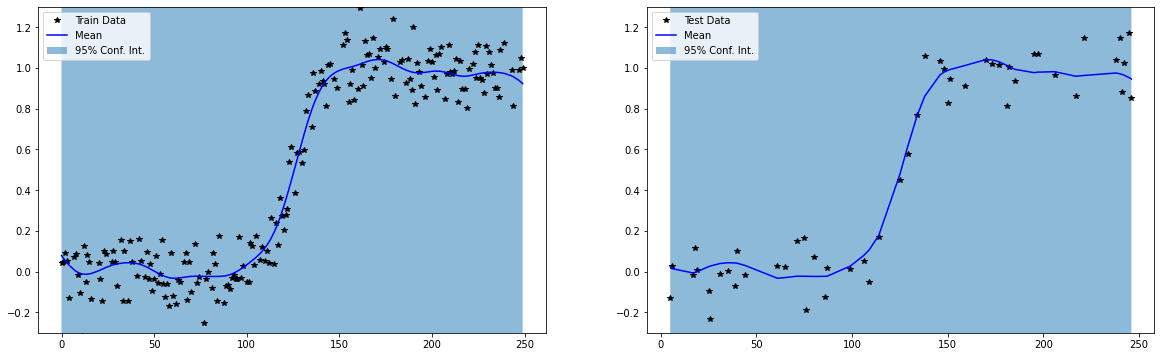

Iter 0/500 - Loss: 0.849   lengthscale: 20.100   noise: 0.644


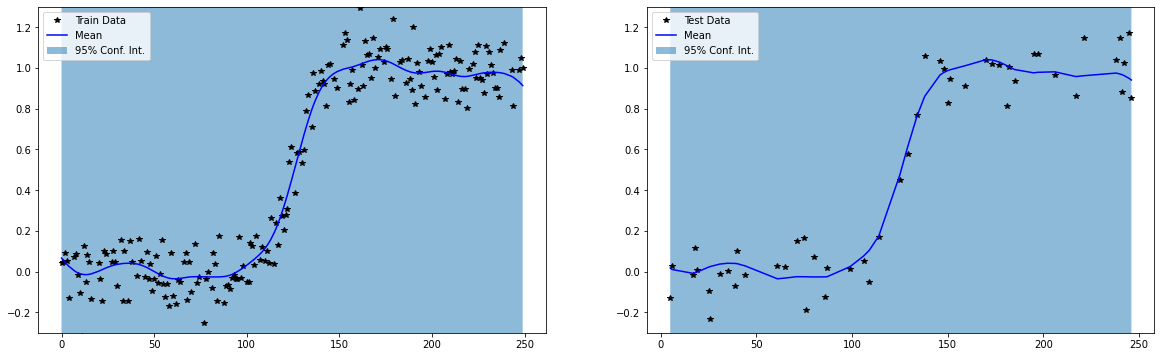

Iter 50/500 - Loss: -0.624   lengthscale: 25.680   noise: 0.009


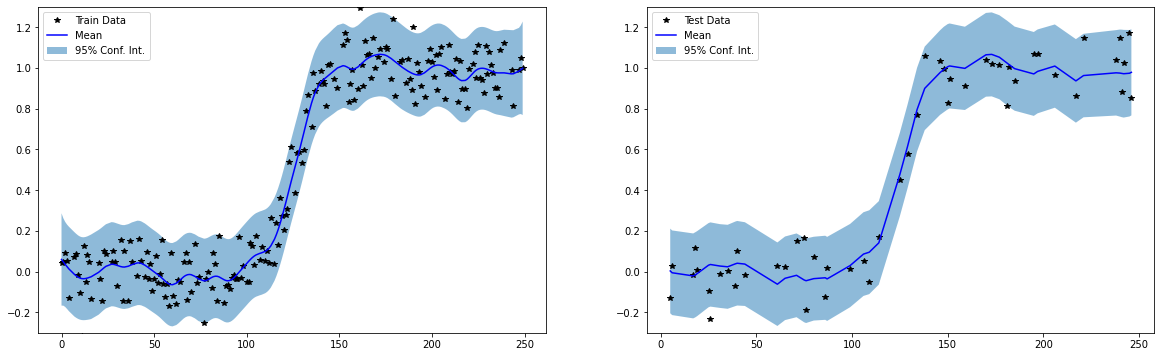

Iter 100/500 - Loss: -0.658   lengthscale: 30.969   noise: 0.010


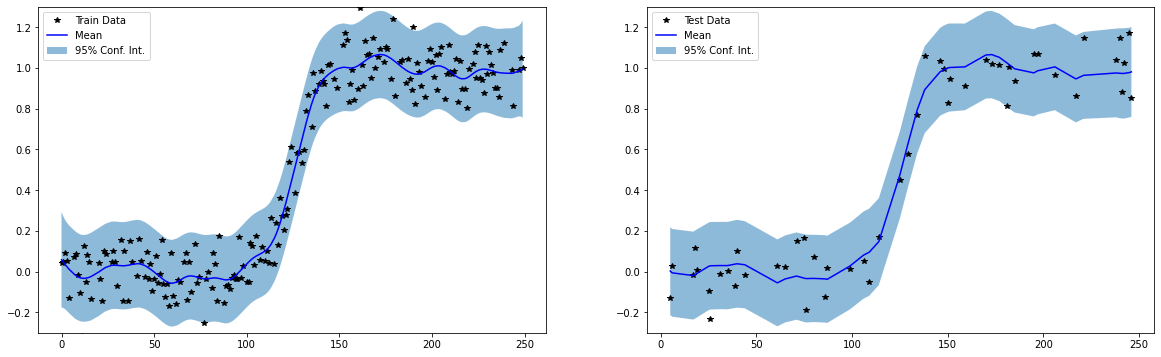

Iter 150/500 - Loss: -0.678   lengthscale: 35.177   noise: 0.010


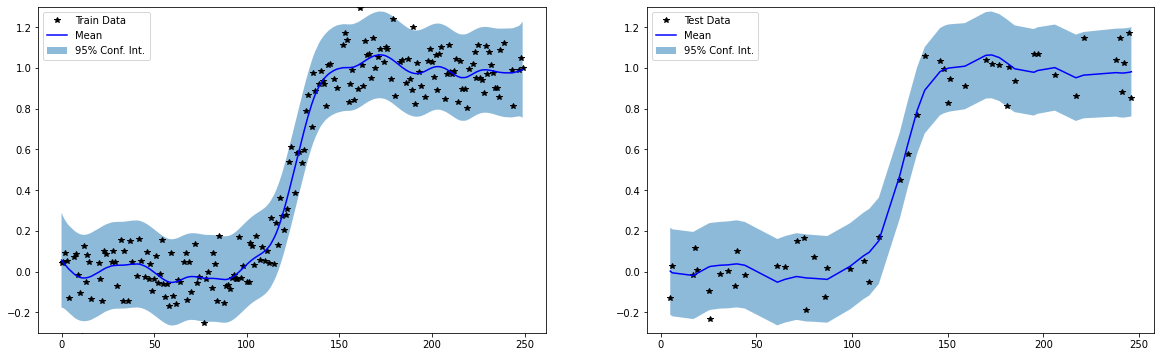

Iter 200/500 - Loss: -0.692   lengthscale: 38.799   noise: 0.010


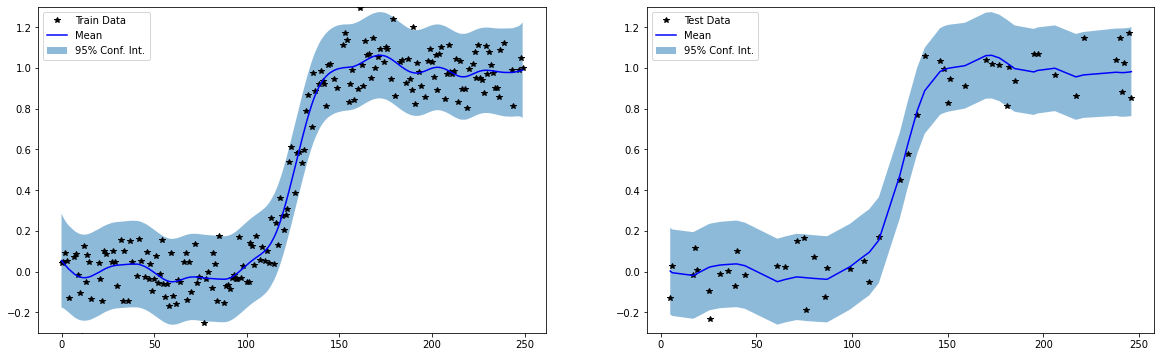

Iter 250/500 - Loss: -0.702   lengthscale: 42.022   noise: 0.010


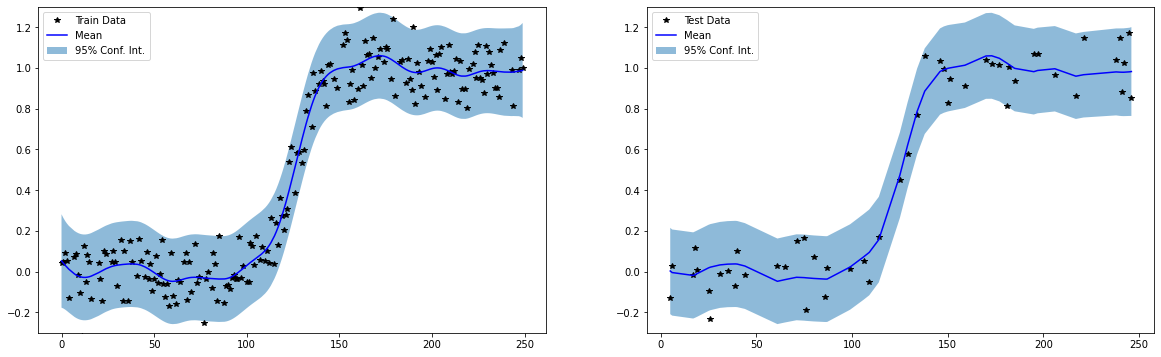

Iter 300/500 - Loss: -0.709   lengthscale: 44.941   noise: 0.010


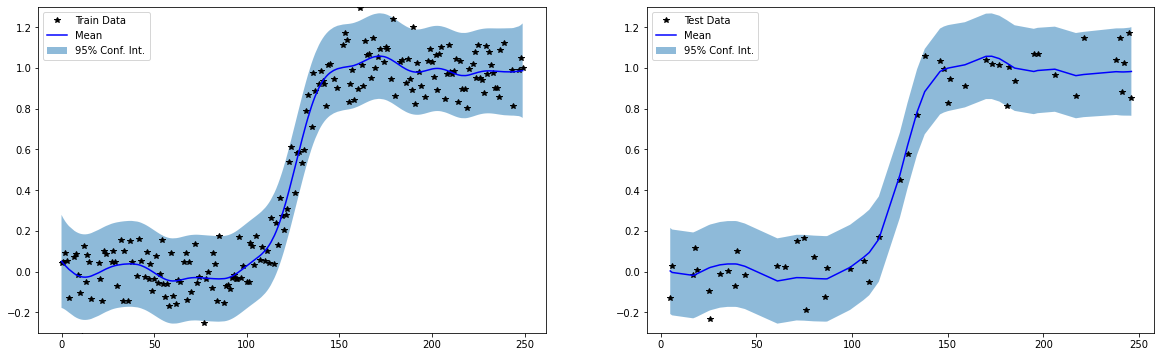

Iter 350/500 - Loss: -0.715   lengthscale: 47.613   noise: 0.010


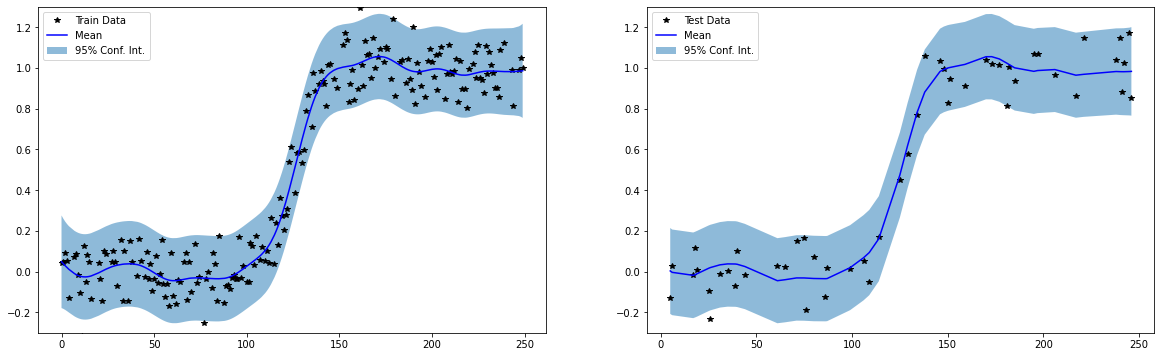

Iter 400/500 - Loss: -0.720   lengthscale: 50.082   noise: 0.010


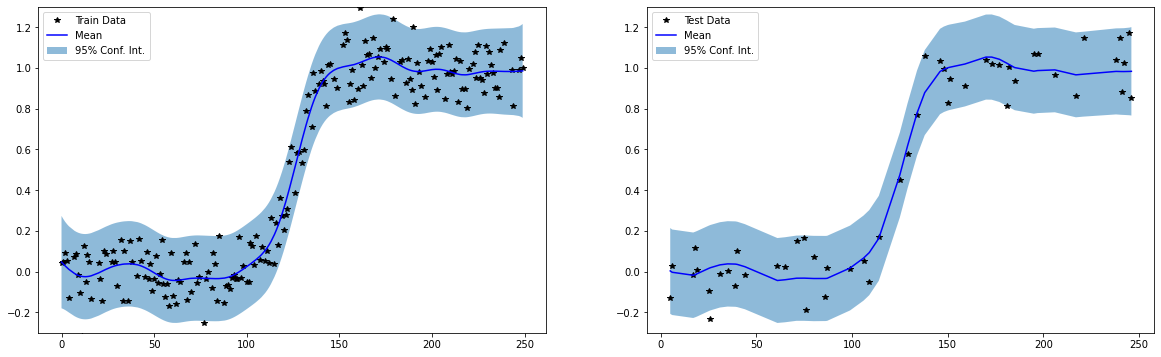

Iter 450/500 - Loss: -0.724   lengthscale: 52.375   noise: 0.010


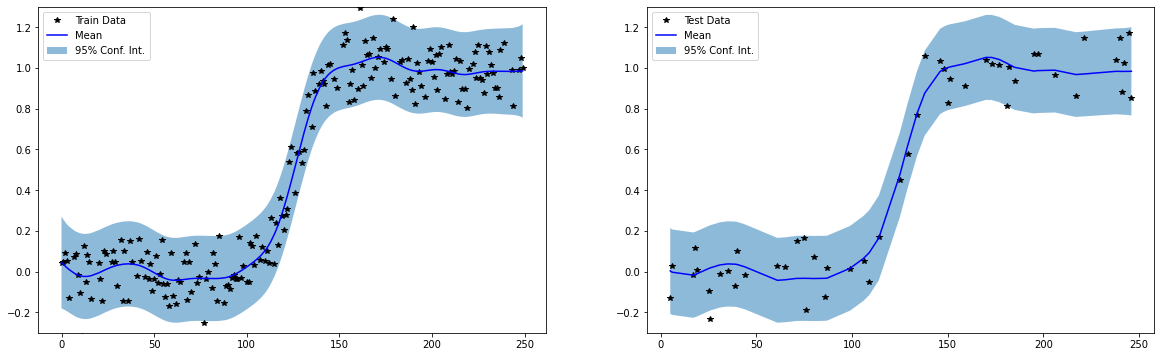

Iter 500/500 - Loss: -0.727   lengthscale: 54.515   noise: 0.010


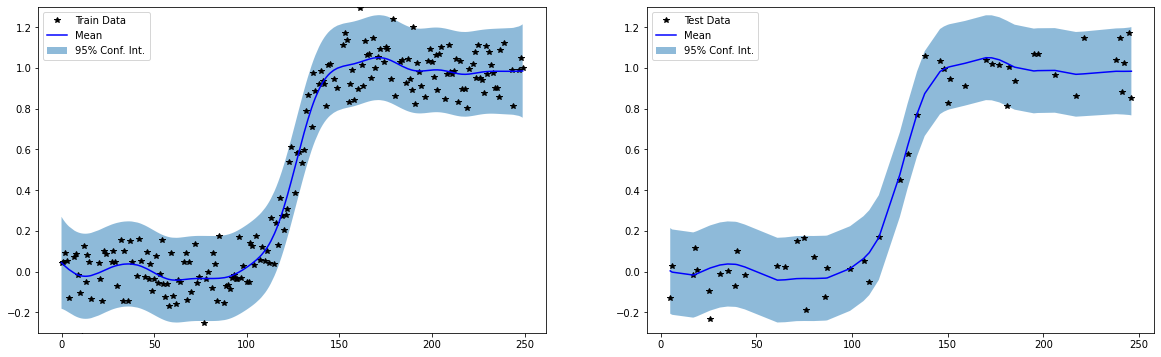

Train RMSE: 0.09594164788722992, Test RMSE: 0.10622317343950272


In [23]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

#set lengthscale and other parameters
matern_kernel = gpytorch.kernels.MaternKernel()
matern_kernel.lengthscale = 20.

model = ExactGPModel(train_x, train_y, likelihood, mean = 0.5, kernel = matern_kernel)

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(501):
    if i == 0:
        print('BEFORE TRAINING')
        print('lengthscale: %.3f   noise: %.3f' % (
            model.covar_module.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        train_mean, test_mean = plot_preds(model, likelihood)

    model.train()
    likelihood.train()

    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()

    optimizer.step()

    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i , 500, loss.item(),
            model.covar_module.lengthscale.item(),
            model.likelihood.noise.item()
        ))

        train_mean, test_mean = plot_preds(model, likelihood)

        train_rmse = np.sqrt(np.mean((train_mean-train_y.numpy())**2))
        test_rmse = np.sqrt(np.mean((test_mean-test_y.numpy())**2))

        if i == 500:
            print('Train RMSE: {}, Test RMSE: {}'.format(train_rmse, test_rmse))